In [14]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [15]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [16]:
from colabgymrender.recorder import Recorder

In [17]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.11).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [18]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [19]:
total_reward

  and should_run_async(code)



-200.0

In [20]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 100000  # Increase this as MountainCar usually needs more steps
epsilon_decay_intervals = 50000
gamma = 0.99  # Discount factor, can keep this the same
alpha = 1e-3  # Learning rate, might need to be adjusted

memory_size = 100000
min_replay_size = 5000
batch_size = 64

target_update_frequency = 1000  # Can keep this the same or adjust as needed

In [21]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0))
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [22]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [23]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.RMSprop(q_net.parameters(), lr=alpha)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        # Modify reward to encourage exploration
        reward = reward + 10*abs(next_state[1])  # Reward velocity
        if next_state[0] >= 0.5:
            reward += 100  # Big reward for reaching the goal
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [24]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -189.84209335400374
Episode: 10 Step: 2000 Average reward: -189.7169246475387
Episode: 15 Step: 3000 Average reward: -187.6169771034471
Episode: 20 Step: 4000 Average reward: -188.23338275945866
Episode: 25 Step: 5000 Average reward: -188.34359237857007
Episode: 30 Step: 6000 Average reward: -188.69699342260375
Episode: 35 Step: 7000 Average reward: -188.88455031942695
Episode: 40 Step: 8000 Average reward: -189.4193359283807
Episode: 45 Step: 9000 Average reward: -189.7622922658185
Episode: 50 Step: 10000 Average reward: -189.6594051236104
Episode: 55 Step: 11000 Average reward: -189.57980473066232
Episode: 60 Step: 12000 Average reward: -189.08775278152453
Episode: 65 Step: 13000 Average reward: -188.81334013951837
Episode: 70 Step: 14000 Average reward: -188.8040540069295
Episode: 75 Step: 15000 Average reward: -188.80725181989024
Episode: 80 Step: 16000 Average reward: -188.86538220041936
Episode: 85 Step: 17000 Average reward: -188.96447005527

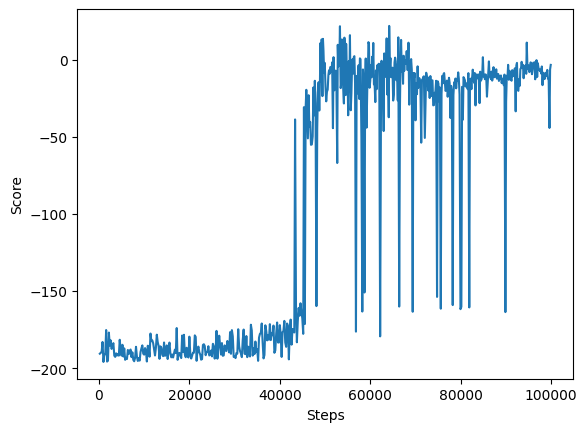

In [25]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [26]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-153.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  and should_run_async(code)



In [ ]:
# Những thay đổi trong code

# Hyperparameters
max_num_steps = 100000
epsilon_decay_intervals = 50000
alpha = 1e-3
memory_size = 100000
min_replay_size = 5000
batch_size = 64


# NeuralNetwork
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0))
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()


# Hàm tiền thưởng
# Modify reward to encourage exploration
reward = reward + 10*abs(next_state[1])  # Reward velocity
if next_state[0] >= 0.5:
    reward += 100  # Big reward for reaching the goal


# Optimizer
optimizer = torch.optim.RMSprop(q_net.parameters(), lr=alpha)


Thách thức chính trong MountainCar là phần thưởng thưa thớt và nhu cầu khám phá một chiến lược không rõ ràng (tích lũy động lượng bằng cách di chuyển qua lại). Những thay đổi này nhằm giải quyết thách thức đó bằng cách:
1. Cho phép khám phá nhiều hơn trong thời gian nhiều hơn (epsilon decay).
2. Cung cấp phần thưởng có ý nghĩa hơn.
3. Sử dụng mạng neural mạnh mẽ hơn.
4. Cho phép thời gian huấn luyện lâu hơn.
5. Sử dụng bộ tối ưu hóa có thể hoạt động tốt hơn với phần thưởng thưa thớt.